<a href="https://colab.research.google.com/github/AnthonyWalujono/BlackJack/blob/master/CPSC_392_Causal_Inference_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>Causal Inference Modeling - IP Weighting</u>

## Why not a normal linear regression?
In standard linear regression, we treat all data equally when creating a line of best fit. If there is bias in the data, the model learns that same bias and the line we create will be slanted away from the true model. If we create weights for our model, similar to a weighted average, we can adjust for the bias that comes from each variable.

## How to adjust for bias:
In causal inference, we care about some intervention that has a causal effect on an outcome typically called **treatment**. Additionally, we need to observe all other common causes of the outcome which are called **confounders**. Confounders are usually, but not exclusively, the variables that bring a bias. We take a few steps to adjust for this bias using the ***IP (inverse probability) Weighting method***:

1. Select only the columns in the data that include the outcome, treatment, and all confounders.

2. Create a logistic regression model (assuming a binary treatment) that has the treatment as the "y" and the confounders as the "X" in our model.

3. Taking the inverse of the probability, or $1/P(treatment)$, from out logistic model as our weights.

4. Create a new linear regression model that predicts the outcome using the treatment, weighted by our inverse probabilities.

5. Interpret the coefficient of the treatment in the model as the casaul effect on the outcome.

## Epidemiologic Followup Study - NHEFS

This NHEFS was a study that analyzed people's living habits, background, and nutrition habits throughout the 70's, 80's, and early 90's. We will primarily be using this dataset to determine the *causal effect of smoking on weight gain*. A full description of the study can be found here:

https://wwwn.cdc.gov/nchs/nhanes/nhefs/#dfd

### Data Dictionary

- **wt82_71**: difference in weight in 1971 and 1982 (outcome)
- **qsmk**: binary indicator if the individual quit smoking (treatment)
- **sex**: 0: men, 1: women
- **age**: age of the individual in 1971
- **race**: 0: white, 1: non-white
- **education**: 1: 8th grade or less, 2: HS dropout, 3: HS, 4:College dropout, 5: College or more
- **wt71**: weight in 1971
- **active**: 0: very active, 1: moderately active, 2: inactive
- **exercise**: 0: much exercise, 1: moderate exercise, 2: little or no exercise
- **smokeintensity**: number of cigarettes per day in 1971
- **smokeyrs**: years of smoking in 1971

In [ ]:
### Import necessary libraries ###
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
### Load the data ###
data = pd.read_csv('https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv')

In [ ]:
### Filter the data to outcome, treatment, and confounders ###
# outcome - wt82_71
# treatment - qsmk
# confounders - sex, age, race, education, wt71, active, exercise, smokeintensity, and smokeyrs
restriction_cols = ['wt82_71', 'qsmk', 'sex', 'age', 'race', 'education', 'wt71', 'active', 'exercise', 'smokeintensity', 'smokeyrs']
data_clean = data[restriction_cols].dropna() # filter to just the columns above
data_clean.head()

,wt82_71,qsmk,sex,age,race,education,wt71,active,exercise,smokeintensity,smokeyrs
0,-10.093960,0,0,42,1,1,79.04,0,2,30,29
1,2.604970,0,0,36,0,2,58.63,0,0,20,24
2,9.414486,0,1,56,1,2,56.81,0,2,20,26
3,4.990117,0,0,68,1,1,59.42,1,2,3,53
4,4.989251,0,0,40,0,2,87.09,1,1,20,19


In [ ]:
### Observe differences in the treated and untreated ###
summaries = OrderedDict((
    ('age', 'mean'),
    ('sex', lambda x: (100 * (x == 0)).mean()),
    ('race', lambda x: (100 * (x == 0)).mean()),
    ('wt71', 'mean'),
    ('smokeintensity', 'mean'),
    ('smokeyrs', 'mean')
))

table = data_clean.groupby('qsmk').agg(summaries)
table.sort_index(ascending=False, inplace=True)
table = table.T

table.index = [
    'Age, years',
    'Men, %',
    'White, %',
    'Weight, kg',
    'Cigarettes/day',
    'Years smoking'
]

table.style.format("{:>0.1f}")

qsmk,1,0
"Age, years",46.2,42.8
"Men, %",54.6,46.6
"White, %",91.1,85.4
"Weight, kg",72.4,70.3
Cigarettes/day,18.6,21.2
Years smoking,26.0,24.1


In [ ]:
### Calculate the inverse probabilities of treatment (qsmk) ###

# Create dummy variables for discrete data
edu_dummies = pd.get_dummies(data_clean.education, prefix='edu')
exercise_dummies = pd.get_dummies(data_clean.exercise, prefix='exercise')
active_dummies = pd.get_dummies(data_clean.active, prefix='active')

# add dummy variables to dataset
train = pd.concat(
    [data_clean, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

train.columns

Index(['wt82_71', 'qsmk', 'sex', 'age', 'race', 'education', 'wt71', 'active',
       'exercise', 'smokeintensity', 'smokeyrs', 'edu_1', 'edu_2', 'edu_3',
       'edu_4', 'edu_5', 'exercise_0', 'exercise_1', 'exercise_2', 'active_0',
       'active_1', 'active_2'],
      dtype='object')

Testing AUC: 64.99 % 

Testing accuracy: 74.90 %

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1528
           1       0.06      0.63      0.11        38

    accuracy                           0.75      1566
   macro avg       0.52      0.69      0.48      1566
weighted avg       0.97      0.75      0.84      1566



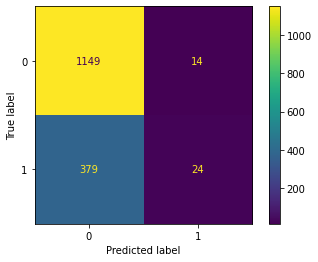

In [ ]:
### YOUR CODE HERE ###
# grab covariates (the confounders) and the treatment
cov = train[['sex', 'age', 'race', 'wt71',
       'smokeintensity', 'smokeyrs', 'edu_1', 'edu_2', 'edu_3',
       'edu_4', 'edu_5', 'exercise_0', 'exercise_1', 'exercise_2', 'active_0',
       'active_1', 'active_2']]
tr = train['qsmk'] # pull our outcome, qsmk and pull it from train


# train a logistic model, with penalty = "none" to determine probabilities of each individual quitting smoking
# using cov and tr from above
logit = LogisticRegression(penalty='none', random_state=392, max_iter=10000)
logit.fit(cov, tr)

# use .predict(), and .predict_proba() to predict both actual treatments and probability of treatment
tr_hat = logit.predict(cov)
tr_hat_probs = logit.predict_proba(cov) #use predict_proba() to predict the probability of quitting smoking
tr_hat_probs = tr_hat_probs[:,1]

### /YOUR CODE HERE ###

# analyze fit of model (not that important, but still worth looking at)
test_accuracy = accuracy_score(tr, tr_hat)*100
test_auc_roc = roc_auc_score(tr, tr_hat_probs)*100
ConfusionMatrixDisplay.from_predictions(tr, tr_hat)
print('Testing AUC: %.2f %%' % test_auc_roc, '\n')
print('Testing accuracy: %.2f %%' % test_accuracy)
print()
print("Classification Report:")
print(classification_report(tr_hat, tr))

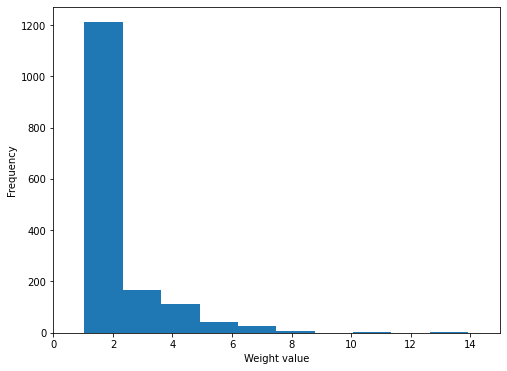

In [ ]:
### Fit weighted linear regression to make causal inference ###
untreated_idx = [idx for idx, val in enumerate(train.qsmk) if val == 0]
tr_hat_probs[untreated_idx] = 1 - tr_hat_probs[untreated_idx] # use 1 - P(tr) for untreated
weights = 1/tr_hat_probs

fig, ax = plt.subplots(figsize=(8, 6))

plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.xlim(0,15)
ax.hist(weights);

In [ ]:


X = data_clean[['qsmk']] # df[[var]] syntax keeps the data as a data frame rather than a series
y = data_clean['wt82_71']

# fit a baseline linear model for comparison
lr_unweighted = LinearRegression(fit_intercept=True)
lr_unweighted = lr_unweighted.fit(X, y)

# our linear regression for causal inference
lr_weighted = LinearRegression(fit_intercept=True)
lr_weighted = lr_weighted.fit(X, y, weights)

# track the treatment effects in both the weighted and unweighted models
biased_effect = lr_unweighted.coef_[0]
causal_effect = lr_weighted.coef_[0]

print('Unweighted Model Coefs:')
print(pd.DataFrame({'coef': [lr_unweighted.intercept_, biased_effect],}, index=['intercept', 'qsmk']))
print()
print('Weighted Model Coefs:')
print(pd.DataFrame({'coef': [lr_weighted.intercept_, causal_effect],}, index=['intercept', 'qsmk']))

Unweighted Model Coefs:
               coef
intercept  1.984498
qsmk       2.540581

Weighted Model Coefs:
               coef
intercept  1.783411
qsmk       3.337162


We can interpret the causal effect of quitting smoking on weight gain to be 3.27kg (~7.2lbs), i.e., quitting smoking can cause someone on average to gain 3.27kgs.

Looking at the unweighted (biased) model, we see that there is a difference in the effect. We can measure this difference:

In [ ]:
# measure percent change of unbiased to biased
bias_pct_chg = ((biased_effect - causal_effect) / biased_effect) * 100
print(f"Bias: {round(bias_pct_chg, 2)} %")

Bias: -31.35 %


We observe that the biased model estimates individual weight gain to be around 29% lower than in reality. While this may seem to be a minor issue in this study, a 29% bias can have a major impact in many areas. For example: drug effectiveness, probability of survival, pollution density, temperature change, etc. We can visualize this bias to further see how the weights in the model adjust the bias on the treatment effect.

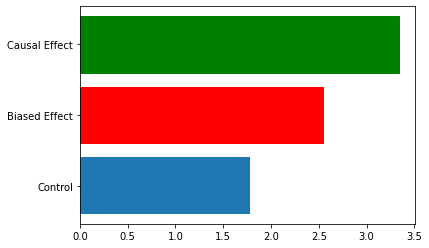

In [ ]:
plot_df = pd.DataFrame({'Name': ['Control', 'Biased Effect', 'Causal Effect'], 'results': [lr_weighted.intercept_, biased_effect, causal_effect]})

barplot = plt.barh(plot_df.Name,plot_df.results)
barplot[1].set_color('r')
barplot[2].set_color('g')
plt.show()